In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-disease-dataset/heart_disease.csv


In [2]:
#Import the dataset and print the path
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mirzahasnine/heart-disease-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/heart-disease-dataset


In [3]:
# Build the full path to the CSV file
file_path = os.path.join(path, "heart_disease.csv")

# Read the CSV into a pandas DataFrame
df = pd.read_csv(file_path)

# Preview the first 5 rows
df.head()

,Gender,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,Heart_ stroke
0,Male,39,postgraduate,0,0.0,0.0,no,0,0,195.0,106.0,70.0,26.97,80.0,77.0,No
1,Female,46,primaryschool,0,0.0,0.0,no,0,0,250.0,121.0,81.0,28.73,95.0,76.0,No
2,Male,48,uneducated,1,20.0,0.0,no,0,0,245.0,127.5,80.0,25.34,75.0,70.0,No
3,Female,61,graduate,1,30.0,0.0,no,1,0,225.0,150.0,95.0,28.58,65.0,103.0,yes
4,Female,46,graduate,1,23.0,0.0,no,0,0,285.0,130.0,84.0,23.10,85.0,85.0,No


## Data Cleaning Log

### Standardization
- Column names normalized (trimmed, lowercase, spaces to underscores).
- Outcome column renamed to `heart_stroke`.

### Encoding and Types
- Binary columns normalized to 0/1 (`currentSmoker`, `BPMeds`, `prevalentStroke`, `prevalentHyp`, `diabetes`, `heart_stroke`).
- Categorical fields standardized:
  - `gender` → `Male` / `Female`
  - `education` → lowercase categories
- Numeric columns coerced to numeric dtypes (`age`, `cigsPerDay`, `totChol`, `sysBP`, `diaBP`, `BMI`, `heartRate`, `glucose`).

### Duplicates
- Exact duplicate rows removed (removed: 0).

### Missing Values
- Missingness observed (percent): glucose 9.16, education 2.48, bpmeds 1.25, totchol 1.18, cigsperday 0.68, bmi 0.45, heartrate 0.02.
- Imputation rules:
  - `education`: mode
  - `bpmeds`: mode
  - numeric (`glucose`, `totchol`, `bmi`, `heartrate`, `cigsperday`): median
  - integrity rule: `currentsmoker == 0` ⇒ `cigsperday = 0`
- Post imputation missingness: 0 across all columns.

### Outliers
- Plausibility range checks applied; flagged: `sysbp` (1), `totchol` (1).
- Implausible values set to NaN and re imputed (median).



In [4]:
# Standardize column names
df = df.copy()

df.columns = (
    df.columns
      .astype(str)
      .str.strip()
      .str.lower()
      .str.replace(" ", "_", regex=False)
      .str.replace("__", "_", regex=False)
)

print("Columns after standardization:")
print(df.columns.tolist())


#Rename target column to a stable name
# Unify any variant of the outcome column into: heart_stroke
target_candidates = [c for c in df.columns if c.replace("_", "") == "heartstroke"]
if len(target_candidates) == 1:
    df = df.rename(columns={target_candidates[0]: "heart_stroke"})
elif "heart_stroke" not in df.columns:
    print("Target column not found. Check df.columns and update the rename logic.")

print("Target column:", "heart_stroke" if "heart_stroke" in df.columns else "NOT FOUND")



# Turn the textdata into numericals

binary_map = {
    "yes": 1, "no": 0,
    "y": 1, "n": 0,
    "true": 1, "false": 0,
    "1": 1, "0": 0
}

def normalize_binary(series: pd.Series) -> pd.Series:
    if series.dtype == "O":
        s = series.astype(str).str.strip().str.lower()
        out = s.map(binary_map)
        out[series.isna()] = np.nan
        return out
    return series

binary_cols = [
    "currentsmoker",
    "bpmeds",
    "prevalentstroke",
    "prevalenthyp",
    "diabetes",
    "heart_stroke"
]

for col in binary_cols:
    if col in df.columns:
        df[col] = normalize_binary(df[col])

print("Binary columns unique values:")
for col in binary_cols:
    if col in df.columns:
        print(col, ":", pd.unique(df[col]))



# Clean all the categorical text fields

if "gender" in df.columns:
    df["gender"] = df["gender"].astype(str).str.strip().str.title()
    df.loc[~df["gender"].isin(["Male", "Female"]), "gender"] = np.nan

if "education" in df.columns:
    df["education"] = df["education"].astype(str).str.strip().str.lower()
    df.loc[df["education"].isin(["nan", "none", ""]), "education"] = np.nan

print("Gender unique values:", df["gender"].dropna().unique() if "gender" in df.columns else "N/A")
print("Education unique values:", df["education"].dropna().unique() if "education" in df.columns else "N/A")



# Properly clean the numeric fields and convert missing ad invalid to NaN

numeric_cols = [
    "age", "cigsperday", "totchol", "sysbp", "diabp",
    "bmi", "heartrate", "glucose"
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

print("\nNumeric dtypes snapshot:")
print(df[[c for c in numeric_cols if c in df.columns]].dtypes)



# Remove exact duplicate rows

dup_count = df.duplicated().sum()
df = df.drop_duplicates()

print("Exact duplicates removed:", dup_count)
print("Shape after duplicate removal:", df.shape)


Columns after standardization:
['gender', 'age', 'education', 'currentsmoker', 'cigsperday', 'bpmeds', 'prevalentstroke', 'prevalenthyp', 'diabetes', 'totchol', 'sysbp', 'diabp', 'bmi', 'heartrate', 'glucose', 'heart_stroke']
Target column: heart_stroke
Binary columns unique values:
currentsmoker : [0 1]
bpmeds : [ 0.  1. nan]
prevalentstroke : [0 1]
prevalenthyp : [0 1]
diabetes : [0 1]
heart_stroke : [0 1]
Gender unique values: ['Male' 'Female']
Education unique values: ['postgraduate' 'primaryschool' 'uneducated' 'graduate']

Numeric dtypes snapshot:
age             int64
cigsperday    float64
totchol       float64
sysbp         float64
diabp         float64
bmi           float64
heartrate     float64
glucose       float64
dtype: object
Exact duplicates removed: 0
Shape after duplicate removal: (4238, 16)


In [5]:
# Missing value handling

df = df.copy()

# Education: mode imputation
if df["education"].isna().any():
    edu_mode = df["education"].mode(dropna=True).iloc[0]
    df["education"] = df["education"].fillna(edu_mode)

# BPMeds: mode imputation (binary)
if df["bpmeds"].isna().any():
    bp_mode = df["bpmeds"].mode(dropna=True).iloc[0]
    df["bpmeds"] = df["bpmeds"].fillna(bp_mode)

# Numeric median imputations
median_impute_cols = ["glucose", "totchol", "bmi", "heartrate", "cigsperday"]
for col in median_impute_cols:
    if col in df.columns and df[col].isna().any():
        df[col] = df[col].fillna(df[col].median())

# Smoking integrity rule: non-smokers should have 0 cigs/day
if set(["currentsmoker", "cigsperday"]).issubset(df.columns):
    df.loc[df["currentsmoker"] == 0, "cigsperday"] = 0


# Check for missing values

missing_after = (df.isna().mean() * 100).sort_values(ascending=False)
missing_after = missing_after[missing_after > 0]
missing_after



Series([], dtype: float64)

In [6]:
# Check for outliers

ranges = {
    "age": (18, 100),
    "sysbp": (70, 260),
    "diabp": (40, 150),
    "bmi": (10, 70),
    "heartrate": (30, 220),
    "glucose": (40, 400),
    "totchol": (80, 600),
    "cigsperday": (0, 80)
}

outlier_counts = {}
for col, (lo, hi) in ranges.items():
    if col in df.columns:
        outlier_counts[col] = int(((df[col] < lo) | (df[col] > hi)).sum())

outlier_counts


# Outlier handling. Values not making sense only

ranges = {
    "age": (18, 100),
    "sysbp": (70, 260),
    "diabp": (40, 150),
    "bmi": (10, 70),
    "heartrate": (30, 220),
    "glucose": (40, 400),
    "totchol": (80, 600),
    "cigsperday": (0, 80)
}

# Flag and null implausible values
for col, (lo, hi) in ranges.items():
    if col in df.columns:
        mask = (df[col] < lo) | (df[col] > hi)
        df.loc[mask, col] = np.nan

# Re-impute only the columns affected by outliers (median)
for col in ["sysbp", "totchol"]:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

# Recheck outliers
outlier_counts = {}
for col, (lo, hi) in ranges.items():
    if col in df.columns:
        outlier_counts[col] = int(((df[col] < lo) | (df[col] > hi)).sum())

outlier_counts


{'age': 0,
 'sysbp': 0,
 'diabp': 0,
 'bmi': 0,
 'heartrate': 0,
 'glucose': 0,
 'totchol': 0,
 'cigsperday': 0}

## Feature Engineering

### Derived Features Created
- **`age_bucket5y`**: age grouped into 5-year intervals (data-driven bin edges based on observed min/max ages) to support finer stratified analysis.
- **`htn_category5`**: hypertension staging expanded into five clinically interpretable groups using `sysbp` and `diabp`:
  - `normal` (SBP < 120 and DBP < 80)
  - `pre_hypertension` (SBP 120–139 or DBP 80–89)
  - `hypertension_1` (SBP 140–159 or DBP 90–99)
  - `hypertension_2` (SBP 160–179 or DBP 100–109)
  - `hypertension_3` (SBP ≥ 180 or DBP ≥ 110)
- **`pulse_pressure`**: `sysbp - diabp` (BP-derived risk proxy).
- **`map`**: `diabp + (pulse_pressure / 3)` (mean arterial pressure proxy).
- **`bmi_category`**: BMI grouped into `underweight`, `normal`, `overweight`, `obese`.
- **Risk flags**
  - `high_chol_flag`: `totchol >= 240`
  - `high_glucose_flag`: `glucose >= 126`
  - `high_bp_flag`: `sysbp >= 140` or `diabp >= 90`
- **Smoking intensity features**
  - `smoker_flag`: mirrors `currentsmoker`
  - `heavy_smoker_flag`: `currentsmoker == 1` and `cigsperday >= 20`
- **`risk_score_simple`**: composite count of selected cardiometabolic indicators (`high_bp_flag`, `high_chol_flag`, `high_glucose_flag`, `diabetes`, `prevalenthyp`).

### Data Integrity Checks Applied
- Enforced BP plausibility for derived BP metrics (`sysbp >= diabp`). Records failing this rule were excluded from `pulse_pressure` and `map` derivations.

### Outcome Signal Snapshot (`heart_stroke`)
- **Age (5-year bands)** shows a monotonic increase in stroke prevalence from early adulthood through older age groups.
- **HTN staging (5 groups)** shows a monotonic increase in stroke prevalence with increasing HTN severity:
  - `normal` (0.086) → `pre_hypertension` (0.136) → `hypertension_1` (0.228) → `hypertension_2` (0.333) → `hypertension_3` (0.441)

**Summary:** The revised feature engineering increases interpretability and stratification resolution, while maintaining physiological validity for derived BP features.


In [7]:
# Feature Engineering

import numpy as np
import pandas as pd

df = df.copy()



# 1) Age buckets (5-year intervals)

age_min = int(np.floor(df["age"].min() / 5) * 5)
age_max = int(np.ceil(df["age"].max() / 5) * 5)

age_bins = list(range(age_min, age_max + 5, 5))
age_labels = [f"{age_bins[i]}-{age_bins[i+1]-1}" for i in range(len(age_bins) - 1)]

df["age_bucket5y"] = pd.cut(
    df["age"],
    bins=age_bins,
    labels=age_labels,
    right=False,
    include_lowest=True
)



# 2) Hypertension staging (5 groups)
#    Normal, Pre-HTN, HTN 1, HTN 2, HTN 3

def htn_5grp(row):
    sbp, dbp = row["sysbp"], row["diabp"]
    if pd.isna(sbp) or pd.isna(dbp):
        return np.nan

    if (sbp < 120) and (dbp < 80):
        return "normal"

    if (120 <= sbp < 140) or (80 <= dbp < 90):
        return "pre_hypertension"

    if (140 <= sbp < 160) or (90 <= dbp < 100):
        return "hypertension_1"

    if (160 <= sbp < 180) or (100 <= dbp < 110):
        return "hypertension_2"

    if (sbp >= 180) or (dbp >= 110):
        return "hypertension_3"

    return np.nan

df["htn_category5"] = df.apply(htn_5grp, axis=1)



# 3) Derived BP features

bp_bad = df["sysbp"] < df["diabp"]
df.loc[bp_bad, ["pulse_pressure", "map"]] = np.nan
df.loc[~bp_bad, "pulse_pressure"] = df.loc[~bp_bad, "sysbp"] - df.loc[~bp_bad, "diabp"]
df.loc[~bp_bad, "map"] = df.loc[~bp_bad, "diabp"] + (df.loc[~bp_bad, "pulse_pressure"] / 3)



# 4) BMI category

df["bmi_category"] = pd.cut(
    df["bmi"],
    bins=[0, 18.5, 25, 30, 100],
    labels=["underweight", "normal", "overweight", "obese"],
    right=False
)



# 5) Risk flags + smoking intensity

df["high_chol_flag"] = (df["totchol"] >= 240).astype(int)
df["high_glucose_flag"] = (df["glucose"] >= 126).astype(int)
df["high_bp_flag"] = ((df["sysbp"] >= 140) | (df["diabp"] >= 90)).astype(int)

df["smoker_flag"] = df["currentsmoker"].astype(int)
df["heavy_smoker_flag"] = ((df["currentsmoker"] == 1) & (df["cigsperday"] >= 20)).astype(int)



# 6) Simple combined-risk count

risk_components = ["high_bp_flag", "high_chol_flag", "high_glucose_flag", "diabetes", "prevalenthyp"]
risk_components = [c for c in risk_components if c in df.columns]
df["risk_score_simple"] = df[risk_components].sum(axis=1)



# 7) Quick verification

df[[
    "age", "age_bucket5y",
    "sysbp", "diabp", "htn_category5",
    "pulse_pressure", "map",
    "bmi", "bmi_category",
    "high_chol_flag", "high_glucose_flag", "high_bp_flag",
    "smoker_flag", "heavy_smoker_flag",
    "risk_score_simple",
    "heart_stroke"
]].head()



# Feature engineering validation (new groupings)


# Age bucket (5-year) distribution
df["age_bucket5y"].value_counts(dropna=False).sort_index()

# HTN 5-group distribution
df["htn_category5"].value_counts(dropna=False)



# Stroke rates using new groupings

# Stroke rate by 5-year age buckets
stroke_by_age5y = df.groupby("age_bucket5y", observed=True)["heart_stroke"].mean().sort_index()

# Stroke rate by HTN 5-group staging
stroke_by_htn5 = df.groupby("htn_category5", observed=True)["heart_stroke"].mean().sort_values(ascending=False)

stroke_by_age5y, stroke_by_htn5


(age_bucket5y
 30-34    0.000000
 35-39    0.043315
 40-44    0.079310
 45-49    0.124051
 50-54    0.177054
 55-59    0.220096
 60-64    0.246654
 65-69    0.369697
 Name: heart_stroke, dtype: float64,
 htn_category5
 hypertension_3      0.441176
 hypertension_2      0.333333
 hypertension_1      0.227545
 pre_hypertension    0.135705
 normal              0.086157
 Name: heart_stroke, dtype: float64)

## Univariate & Multivariate Analysis (Target: `heart_stroke`)

### Target distribution
- `heart_stroke = 0`: 3594  
- `heart_stroke = 1`: 644  
- Prevalence: 0.152

### Univariate analysis

**Numeric features (central tendency and dispersion)**
- Age: median 49, IQR 14
- SBP (`sysbp`): median 128, IQR 27
- DBP (`diabp`): median 82, IQR 14.875
- Total cholesterol (`totchol`): median 234, IQR 56
- BMI: median 25.4, IQR 4.9575
- Glucose: median 78, IQR 13
- Heart rate (`heartrate`): median 75, IQR 15
- Cigarettes/day (`cigsperday`): median 0, IQR 20
- Pulse pressure: median 47, IQR 16
- MAP: median 97.33, IQR 17.5

**Categorical features (distributions)**
- Sex: Female 2419, Male 1819
- Hypertension stage (5 groups): pre_hypertension 2277, normal 1033, hypertension_1 668, hypertension_2 192, hypertension_3 68
- Additional categorical variables (education, BMI category, smoking intensity, comorbidity flags) were summarized via frequency tables and compared by target rate.

### Cross-tabulations by target (stroke rate patterns)
- Age shows a strong monotonic gradient in stroke rate across 5-year bands:
  - 35–39: 0.043 → 65–69: 0.370 (increasing with age)
- Hypertension staging shows a strong monotonic gradient:
  - normal: 0.086 → hypertension_3: 0.441 (increasing with HTN severity)

### Multivariate analysis (stratified risk tables)

**Age (5-year) × HTN stage**
- Stroke risk increases along two dimensions:
  - Within each age band, higher HTN stage corresponds to higher stroke prevalence.
  - Within each HTN stage, older age bands show higher stroke prevalence.
- Extreme values in `hypertension_3` cells should be interpreted with caution due to smaller subgroup counts.

**Sex × HTN stage**
- Males show consistently higher stroke prevalence than females across HTN stages:
  - Normal: Female 0.069 vs Male 0.115
  - Pre-hypertension: Female 0.114 vs Male 0.161
  - Hypertension_1: Female 0.178 vs Male 0.293
  - Hypertension_2: Female 0.245 vs Male 0.442
  - Hypertension_3: Female 0.438 vs Male 0.450

**Sex × Combined risk (`risk_score_simple`)**
- Stroke prevalence increases monotonically with the combined-risk score for both sexes.
- Males remain higher than females at each score level; the highest-score categories may have small counts and should be interpreted cautiously.



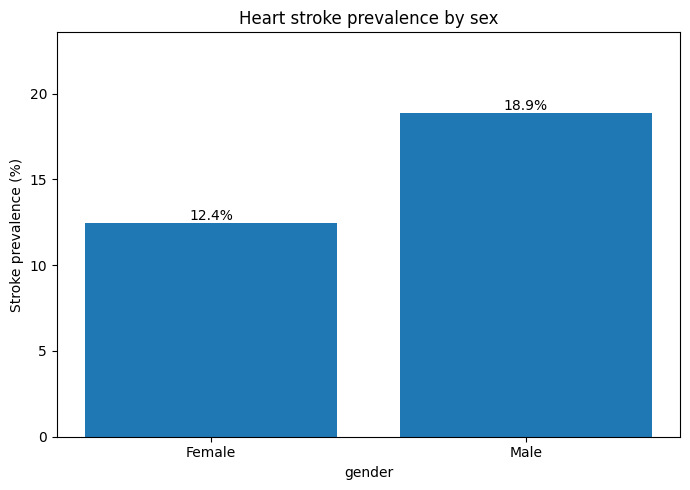

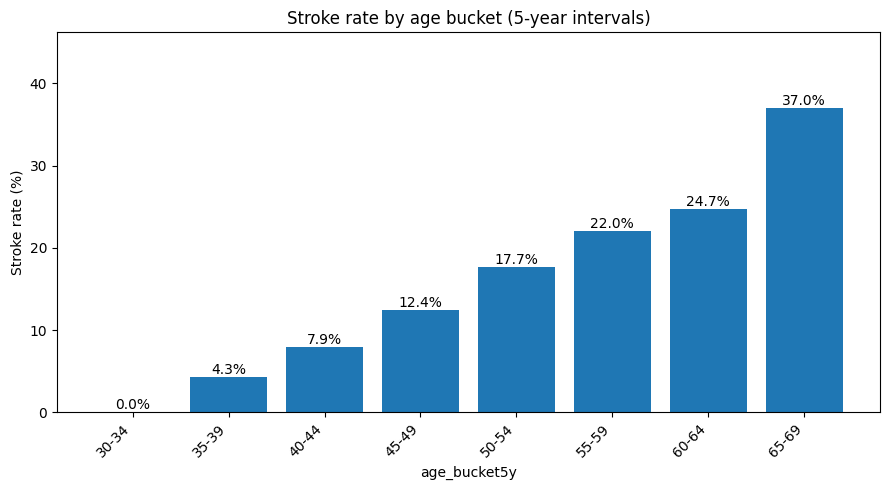

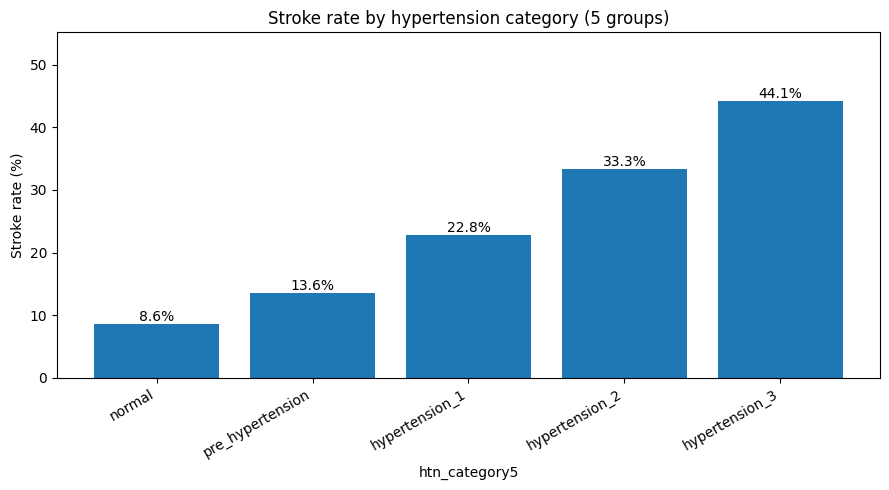

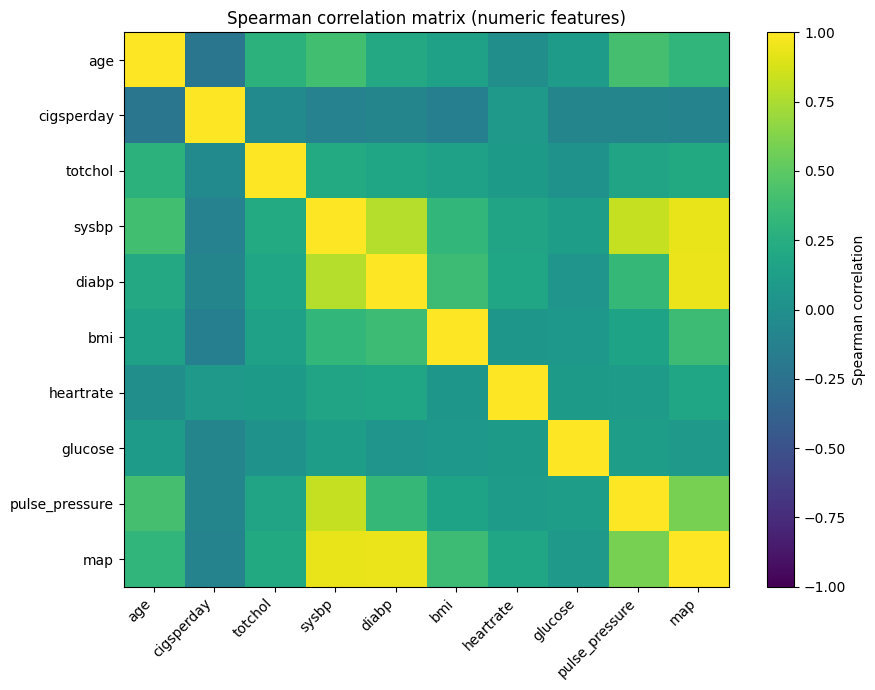

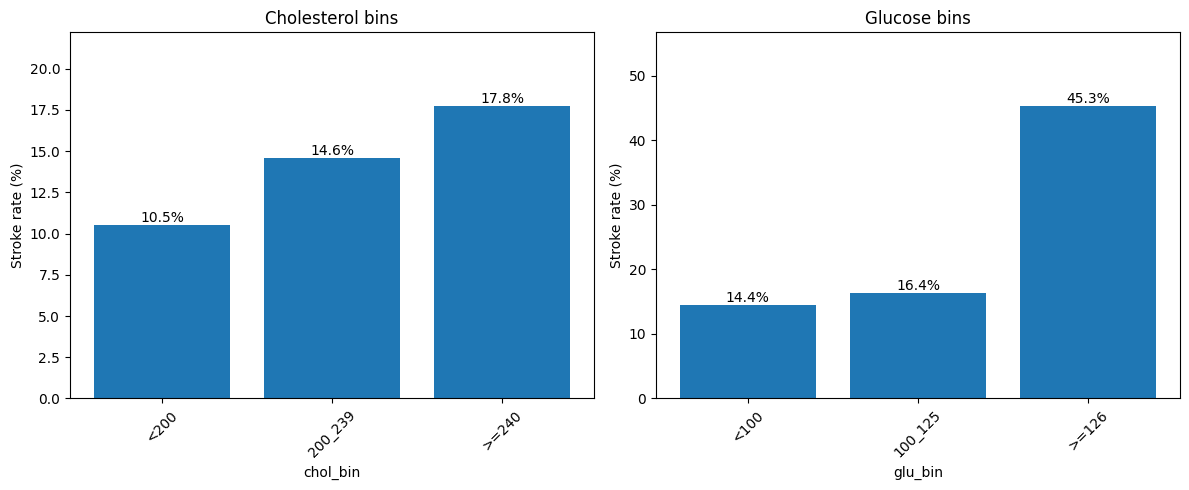

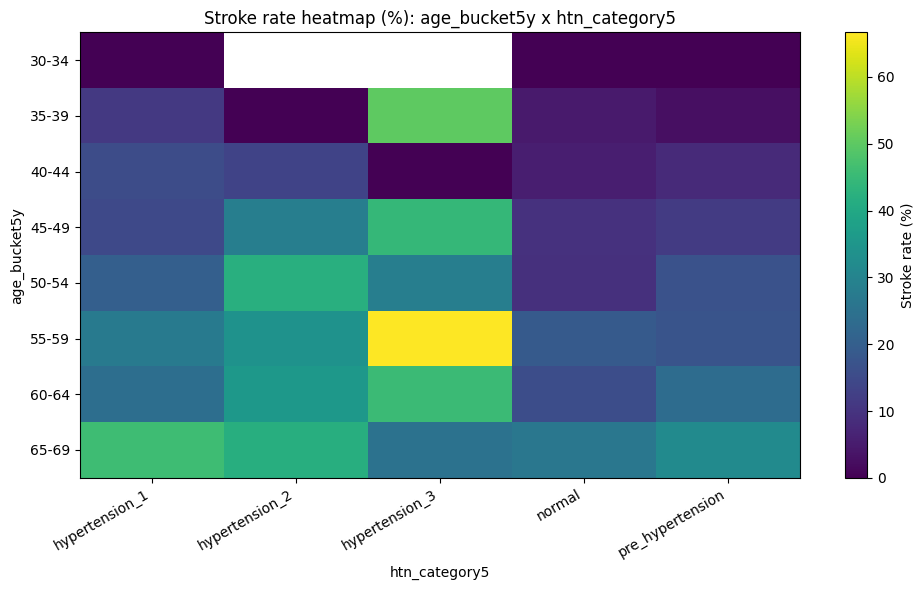

In [8]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TARGET = "heart_stroke"
OUT_DPI = 200


# FIG 1 (Q1): Prevalence by sex

prev_by_sex = (df.groupby("gender", observed=True)[TARGET].mean() * 100).sort_index()

fig, ax = plt.subplots(figsize=(7,5))
ax.bar(prev_by_sex.index.astype(str), prev_by_sex.values)
ax.set_title("Heart stroke prevalence by sex")
ax.set_xlabel("gender")
ax.set_ylabel("Stroke prevalence (%)")
ax.set_ylim(0, prev_by_sex.max() * 1.25)

for i, v in enumerate(prev_by_sex.values):
    ax.text(i, v, f"{v:.1f}%", ha="center", va="bottom")

plt.tight_layout()
plt.savefig("fig1_q1_prevalence_by_sex_percent.png", dpi=OUT_DPI)
plt.show()



# FIG 2 (Q2): Stroke rate by 5-year age buckets

age_rate = (df.groupby("age_bucket5y", observed=True)[TARGET].mean() * 100).sort_index()

fig, ax = plt.subplots(figsize=(9,5))
ax.bar(age_rate.index.astype(str), age_rate.values)
ax.set_title("Stroke rate by age bucket (5-year intervals)")
ax.set_xlabel("age_bucket5y")
ax.set_ylabel("Stroke rate (%)")
ax.set_ylim(0, age_rate.max() * 1.25)
plt.xticks(rotation=45, ha="right")

for i, v in enumerate(age_rate.values):
    ax.text(i, v, f"{v:.1f}%", ha="center", va="bottom")

plt.tight_layout()
plt.savefig("fig2_q2_stroke_rate_by_age_bucket5y_percent.png", dpi=OUT_DPI)
plt.show()



# FIG 3 (Q2/Q3): Stroke rate by HTN category 

htn_rate = (df.groupby("htn_category5", observed=True)[TARGET].mean() * 100).sort_values()

fig, ax = plt.subplots(figsize=(9,5))
ax.bar(htn_rate.index.astype(str), htn_rate.values)
ax.set_title("Stroke rate by hypertension category (5 groups)")
ax.set_xlabel("htn_category5")
ax.set_ylabel("Stroke rate (%)")
ax.set_ylim(0, htn_rate.max() * 1.25)
plt.xticks(rotation=30, ha="right")

for i, v in enumerate(htn_rate.values):
    ax.text(i, v, f"{v:.1f}%", ha="center", va="bottom")

plt.tight_layout()
plt.savefig("fig3_q3_stroke_rate_by_htn_category5_percent.png", dpi=OUT_DPI)
plt.show()


# FIG 4 (Q5): Spearman correlation matrix 

num_cols = [c for c in ["age","cigsperday","totchol","sysbp","diabp","bmi","heartrate","glucose","pulse_pressure","map"] if c in df.columns]
corr = df[num_cols].corr(method="spearman")

fig, ax = plt.subplots(figsize=(9,7))
im = ax.imshow(corr.values, aspect="auto", vmin=-1, vmax=1)
ax.set_title("Spearman correlation matrix (numeric features)")
ax.set_xticks(range(len(num_cols)))
ax.set_yticks(range(len(num_cols)))
ax.set_xticklabels(num_cols, rotation=45, ha="right")
ax.set_yticklabels(num_cols)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Spearman correlation")

plt.tight_layout()
plt.savefig("fig4_q5_spearman_correlation_matrix.png", dpi=OUT_DPI)
plt.show()

# Flag highly correlated pairs (absolute)
abs_corr = corr.abs()
pairs = (abs_corr.where(np.triu(np.ones(abs_corr.shape), k=1).astype(bool))
                .stack()
                .sort_values(ascending=False))




# FIG 5 (Q6): Binned cholesterol + glucose vs stroke rate

df_plot = df.copy()

df_plot["chol_bin"] = pd.cut(
    df_plot["totchol"],
    bins=[-np.inf, 199, 239, np.inf],
    labels=["<200", "200_239", ">=240"]
)

df_plot["glu_bin"] = pd.cut(
    df_plot["glucose"],
    bins=[-np.inf, 99, 125, np.inf],
    labels=["<100", "100_125", ">=126"]
)

chol_rates = df_plot.groupby("chol_bin", observed=True)[TARGET].mean() * 100
glu_rates  = df_plot.groupby("glu_bin", observed=True)[TARGET].mean() * 100

fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].bar(chol_rates.index.astype(str), chol_rates.values)
axs[0].set_title("Cholesterol bins")
axs[0].set_xlabel("chol_bin")
axs[0].set_ylabel("Stroke rate (%)")
axs[0].set_ylim(0, chol_rates.max() * 1.25)
axs[0].tick_params(axis="x", rotation=45)
for i, v in enumerate(chol_rates.values):
    axs[0].text(i, v, f"{v:.1f}%", ha="center", va="bottom")

axs[1].bar(glu_rates.index.astype(str), glu_rates.values)
axs[1].set_title("Glucose bins")
axs[1].set_xlabel("glu_bin")
axs[1].set_ylabel("Stroke rate (%)")
axs[1].set_ylim(0, glu_rates.max() * 1.25)
axs[1].tick_params(axis="x", rotation=45)
for i, v in enumerate(glu_rates.values):
    axs[1].text(i, v, f"{v:.1f}%", ha="center", va="bottom")

plt.tight_layout()
plt.savefig("fig5_q6_chol_glucose_binned_rates_percent.png", dpi=OUT_DPI)
plt.show()


# FIG 6: Heatmap (age_bucket x htn_category)

pivot_age_htn = (pd.pivot_table(
    df,
    index="age_bucket5y",
    columns="htn_category5",
    values=TARGET,
    aggfunc="mean",
    observed=True
) * 100).sort_index()

fig, ax = plt.subplots(figsize=(10,6))
im = ax.imshow(pivot_age_htn.values, aspect="auto")

ax.set_title("Stroke rate heatmap (%): age_bucket5y x htn_category5")
ax.set_xlabel("htn_category5")
ax.set_ylabel("age_bucket5y")
ax.set_xticks(range(pivot_age_htn.shape[1]))
ax.set_yticks(range(pivot_age_htn.shape[0]))
ax.set_xticklabels(pivot_age_htn.columns.astype(str), rotation=30, ha="right")
ax.set_yticklabels(pivot_age_htn.index.astype(str))

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Stroke rate (%)")

plt.tight_layout()
plt.savefig("fig6_stratified_heatmap_age_by_htn_percent.png", dpi=OUT_DPI)
plt.show()



## Correlation & Association (Target: `heart_stroke`)

### Correlation matrix (numeric features)
- A Spearman correlation matrix was computed across numeric variables to characterize monotonic relationships and reduce sensitivity to skewness and outliers typical of clinical measurements.
- A strong blood-pressure cluster is present: `sysbp` and `diabp` are strongly correlated, and both show strong correlation with BP-derived features (`map`, `pulse_pressure`). These relationships reflect shared measurement origin and mathematical dependence for derived metrics.
- Other numeric variables (e.g., `totchol`, `bmi`, `glucose`, `cigsperday`, `heartrate`) show weaker to moderate correlations relative to the BP cluster.

### Point-biserial correlation (numeric features vs target)
- Point-biserial correlation was used to quantify association between each numeric feature and the binary outcome (`heart_stroke`).
- The resulting table (`pb_table`) ranks numeric variables by p-value and correlation magnitude, highlighting which continuous measures best separate cases from controls in this dataset.

### Chi-square association tests (categorical features vs target)
- Chi-square tests were computed for categorical features to assess dependence with `heart_stroke` (e.g., `gender`, `education`, `age_bucket5y`, `htn_category5`, BMI category, smoking intensity, and comorbidity flags).
- The resulting table (`chi_table`) provides test statistics and p-values, enabling ranking of categorical predictors by strength of evidence against independence.

### Visualizations of key relationships
- **Numeric vs target:** boxplot of the strongest point-biserial numeric feature to visualize distribution shifts between `heart_stroke = 0` and `heart_stroke = 1`.
- **Age vs target:** stroke rate by `age_bucket5y` to show the age gradient in outcome prevalence.
- **Hypertension vs target:** stroke rate by `htn_category5` to show monotonic risk increase across HTN severity groups.


## Stratified Analysis (Target: `heart_stroke`)

### Sex × High cholesterol (`high_chol_flag`)
- Female: 0.102 (no high chol) vs 0.149 (high chol)
- Male: 0.166 (no high chol) vs 0.221 (high chol)  
**Pattern:** High cholesterol is associated with higher stroke prevalence in both sexes; males remain higher than females within each cholesterol stratum.

### Sex × Hypertension severity (`htn_category5`)
- Normal: Female 0.069 vs Male 0.115
- Pre-hypertension: Female 0.114 vs Male 0.161
- Hypertension_1: Female 0.178 vs Male 0.293
- Hypertension_2: Female 0.245 vs Male 0.442
- Hypertension_3: Female 0.438 vs Male 0.450  
**Pattern:** Stroke prevalence increases with HTN severity for both sexes. Males show higher risk at every HTN stage; the highest stage has similar rates across sexes.

### Sex × Diabetes (`diabetes`)
- Female: 0.120 (no diabetes) vs 0.316 (diabetes)
- Male: 0.182 (no diabetes) vs 0.423 (diabetes)  
**Pattern:** Diabetes is associated with substantially higher stroke prevalence in both sexes.

### Sex × Hypertension history (`prevalenthyp`)
- Female: 0.079 (no) vs 0.225 (yes)
- Male: 0.149 (no) vs 0.275 (yes)  
**Pattern:** A history of hypertension is associated with higher stroke prevalence for both sexes.

### Sex × High glucose (`high_glucose_flag`)
- Female: 0.120 (no high glucose) vs 0.395 (high glucose)
- Male: 0.181 (no high glucose) vs 0.512 (high glucose)  
**Pattern:** High glucose is associated with a strong increase in stroke prevalence; interpretation should account for the relatively small high-glucose subgroup.

### Sex × BP medication status (`bpmeds`)
- Female: 0.117 (no meds) vs 0.315 (on meds)
- Male: 0.185 (no meds) vs 0.371 (on meds)  
**Pattern:** Patients on BP meds show higher stroke prevalence in both sexes, consistent with treatment being a marker for elevated baseline cardiovascular risk rather than a causal effect.


In [9]:
# Stratified analysis (risk by age groups, sex, key comorbid indicators)

import pandas as pd


# 1) Age group x Sex

risk_age_sex = df.pivot_table(
    index="age_bucket5y",
    columns="gender",
    values="heart_stroke",
    aggfunc="mean",
    observed=True
).sort_index()

risk_age_sex



# 2) Age group x Hypertension (5 groups)

risk_age_htn = df.pivot_table(
    index="age_bucket5y",
    columns="htn_category5",
    values="heart_stroke",
    aggfunc="mean",
    observed=True
).sort_index()

risk_age_htn



# 3) Age group x High cholesterol

risk_age_chol = df.pivot_table(
    index="age_bucket5y",
    columns="high_chol_flag",
    values="heart_stroke",
    aggfunc="mean",
    observed=True
).sort_index()

risk_age_chol



# 4) Sex x Key comorbid indicators

sex_comorbid_cols = ["high_chol_flag", "htn_category5", "diabetes", "prevalenthyp", "high_glucose_flag", "bpmeds"]
sex_comorbid_cols = [c for c in sex_comorbid_cols if c in df.columns]

risk_sex_comorbids = {
    c: df.pivot_table(
        index="gender",
        columns=c,
        values="heart_stroke",
        aggfunc="mean",
        observed=True
    )
    for c in sex_comorbid_cols
}

risk_sex_comorbids


{'high_chol_flag': high_chol_flag         0         1
 gender                            
 Female          0.102264  0.149385
 Male            0.166202  0.221024,
 'htn_category5': htn_category5  hypertension_1  hypertension_2  hypertension_3    normal  \
 gender                                                                    
 Female               0.178478        0.245283          0.4375  0.069018   
 Male                 0.292683        0.441860          0.4500  0.115486   
 
 htn_category5  pre_hypertension  
 gender                           
 Female                 0.114448  
 Male                   0.160766  ,
 'diabetes': diabetes         0         1
 gender                      
 Female    0.119814  0.315789
 Male      0.181664  0.423077,
 'prevalenthyp': prevalenthyp         0         1
 gender                          
 Female        0.079498  0.225201
 Male          0.148919  0.275439,
 'high_glucose_flag': high_glucose_flag         0         1
 gender                    

## Risk Profiling & Ranking (Target: `heart_stroke`)

### Combined-risk score construction
A simple interpretable risk score (`risk_score_simple2`) was defined as the **count of six binary risk indicators** per patient:

- `high_bp_flag`
- `high_chol_flag`
- `high_glucose_flag`
- `diabetes`
- `heavy_smoker_flag`
- `prevalenthyp`

This produces a score from **0 to 6**, where higher values indicate a greater accumulation of measured risk signals.

### Risk ranking and stratification
Patients were ranked by `risk_score_simple2` and split into **five equally-sized risk buckets (quintiles)**:

| Risk bucket | Count | Stroke rate |
|---|---:|---:|
| Q1_low | 848 | 0.076651 |
| Q2 | 847 | 0.100354 |
| Q3 | 848 | 0.126179 |
| Q4 | 847 | 0.186541 |
| Q5_high | 848 | 0.270047 |

**Pattern:** Stroke prevalence increases monotonically from Q1_low to Q5_high, indicating that the score provides meaningful separation of outcome risk across the dataset.

### Highest-risk case profiles (Top-10)
The top-ranked stroke cases (all within `Q5_high`) are characterized by **very high composite scores (5–6)**, meaning **5 or all 6** risk flags are present simultaneously. These top cases typically combine:
- Elevated BP burden (`high_bp_flag=1` and/or advanced `htn_category5`)
- Elevated cholesterol and glucose burden (`high_chol_flag=1`, `high_glucose_flag=1`)
- Diabetes and/or hypertension history (`diabetes=1`, `prevalenthyp=1`)
- Smoking intensity present in a subset (`heavy_smoker_flag=1` for some cases)

**Summary:** The highest-risk profiles are driven by stacked cardiometabolic burden (BP + cholesterol + glucose/diabetes) and comorbidity history, with smoking intensity contributing for a subset of individuals.


In [10]:
# SIMPLE Risk Profiling & Ranking (pivot table output)

import pandas as pd

# 1) Simple combined risk score (count of flags)
risk_flags = [
    "high_bp_flag",
    "high_chol_flag",
    "high_glucose_flag",
    "diabetes",
    "heavy_smoker_flag",
    "prevalenthyp"
]
risk_flags = [c for c in risk_flags if c in df.columns]

df["risk_score_simple2"] = df[risk_flags].sum(axis=1)

# 2) Create 5 risk buckets (quintiles) safely (rank breaks ties)
ranked = df["risk_score_simple2"].rank(method="first")
df["risk_bucket2"] = pd.qcut(ranked, q=5, labels=["Q1_low","Q2","Q3","Q4","Q5_high"])

# 3) Pivot table: count + stroke rate per risk bucket
risk_pivot = df.pivot_table(
    index="risk_bucket2",
    values="heart_stroke",
    aggfunc=["count", "mean"],
    observed=True
)

risk_pivot.columns = ["count", "stroke_rate"]
risk_pivot


,count,stroke_rate
risk_bucket2,,
Q1_low,848,0.076651
Q2,847,0.100354
Q3,848,0.126179
Q4,847,0.186541
Q5_high,848,0.270047


In [11]:
top10_cases = (df[df["heart_stroke"] == 1]
               .sort_values(["risk_score_simple2","age"], ascending=[False, False])
               .head(10))

top10_cases[[
    "gender","age","age_bucket5y","htn_category5",
    "high_bp_flag","high_chol_flag","high_glucose_flag","diabetes","heavy_smoker_flag","prevalenthyp",
    "risk_score_simple2","risk_bucket2","heart_stroke"
]]


,gender,age,age_bucket5y,htn_category5,high_bp_flag,high_chol_flag,high_glucose_flag,diabetes,heavy_smoker_flag,prevalenthyp,risk_score_simple2,risk_bucket2,heart_stroke
3844,Female,62.0,60-64,hypertension_3,1,1,1,1,1,1,6,Q5_high,1
3817,Male,47.0,45-49,hypertension_1,1,1,1,1,1,1,6,Q5_high,1
2909,Female,67.0,65-69,hypertension_1,1,1,1,1,0,1,5,Q5_high,1
2091,Male,65.0,65-69,hypertension_2,1,1,1,1,0,1,5,Q5_high,1
2870,Male,63.0,60-64,pre_hypertension,1,1,1,0,1,1,5,Q5_high,1
604,Male,62.0,60-64,pre_hypertension,1,1,1,0,1,1,5,Q5_high,1
4076,Female,61.0,60-64,hypertension_3,1,1,1,1,0,1,5,Q5_high,1
763,Female,58.0,55-59,hypertension_1,1,1,1,1,0,1,5,Q5_high,1
1931,Female,58.0,55-59,pre_hypertension,1,1,1,1,0,1,5,Q5_high,1
2378,Male,58.0,55-59,hypertension_1,1,1,1,1,0,1,5,Q5_high,1


## Data Quality & Ethics Notes

### Data quality issues observed
- **Missingness:** Several features had missing values (largest in `glucose`), requiring imputation; this introduces uncertainty and may reduce reliability of any downstream conclusions involving those variables.
- **Encoding inconsistencies:** Mixed encodings were present in binary and categorical fields (e.g., `yes/no`, `0/1`, casing), which were standardized to avoid misclassification.
- **Physiological inconsistencies:** At least one record violated basic clinical plausibility (`sysbp < diabp`), indicating measurement or entry error; derived BP features were not computed for that record.
- **Feature dependence:** Derived features (`pulse_pressure`, `map`) are mathematically dependent on BP measurements; interpretations must account for redundancy when comparing predictors.

### Bias and representativeness risks
- **Sampling bias:** The dataset may not be representative of the general population (e.g., restricted geography, clinic-based sampling, or specific study cohort). Estimated risks and relationships may not generalize.
- **Measurement bias:** Clinical variables (BP, cholesterol, glucose, BMI) can reflect single-time measurements and may include device, protocol, or reporting variability. Some conditions (e.g., smoking) may be self-reported, introducing reporting bias.
- **Class imbalance:** The outcome prevalence is ~0.152, meaning the dataset is imbalanced. Model evaluation and interpretation should avoid accuracy-only reporting and use prevalence-aware metrics later.
- **Small subgroup instability:** Some risk flags have very small positive counts (e.g., `prevalentstroke`, `high_glucose_flag`), so subgroup rates can look extreme and should be interpreted cautiously.

### Privacy and ethical considerations
- **De-identification assumption:** The dataset is treated as non-identifiable. No attempt should be made to re-identify individuals or link records to external data sources.
- **Minimization:** Analyses should use only the variables needed to answer the clinical-style questions; avoid exposing row-level data in reports.
- **Fairness and harm avoidance:** Observed differences by sex, education, or other socio-demographics should be framed as associations in this dataset, not causal claims. Avoid stigmatizing interpretations and consider confounding.
- **Clinical caution:** Results are descriptive and do not constitute medical advice. Any risk scoring presented is for analytical insight, not clinical decision-making without validation.
